# Ensemble reduction

This tutorial will explore ensemble reduction (also known as ensemble selection) using `xscen`. This will use the catalog from the Getting Started notebook, so make sure you run GettingStarted.ipynb before this one.

In [1]:
import xscen as xs
from pathlib import Path

# Open the Getting Started catalog
gettingStarted_cat = xs.DataCatalog(f"{Path().absolute()}/samples/example-gettingstarted.json")

## Preparing the data

Ensemble reduction is built upon climate indicators that are relevant to represent the ensemble's variability for a given application. In the case of Getting Started, two indicators were computed:

In [2]:
gettingStarted_cat.search(processing_level="deltas").unique("variable")

['tg_min_delta_2000_2004', 'growing_degree_days_delta_2000_2004']

However, the functions implemented in `xclim.ensembles._reduce` require a very specific 2-D DataArray of dimensions "realization" and "criteria". That means that all the variables need to be combined and renamed, and that all dimensions need to be stacked together.

`xs.build_reduction_data` can be used to prepare the data for ensemble reduction. Its arguments are:

- `datasets` (dict, list)
- `xrfreqs` are the unique frequencies of the indicators.
- `horizons` is used to instruct on which horizon(s) to build the data from.

Because a simulation could have multiple datasets (in the case of multiple frequencies), an attempt will be made to decipher the ID and frequency from the metadata.

In [3]:
ds_dict = gettingStarted_cat.search(processing_level="deltas", domain="regular0-25")
data = xs.build_reduction_data(
    datasets=ds_dict.to_dataset_dict(),
    xrfreqs = ds_dict.unique("xrfreq"), 
    horizons=['2005-2009', '2010-2014']
    )

data


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


<xarray.DataArray 'values' (realization: 5, criteria: 64)>
dask.array<concatenate, shape=(5, 64), dtype=float64, chunksize=(1, 32), chunktype=numpy.ndarray>
Coordinates:
  * realization  (realization) <U63 'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_...
  * criteria     (criteria) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Attributes:
    long_name:  criteria for ensemble selection

The number of criteria corresponds to: `indicators x horizons x longitude x latitude`, but criteria that are purely NaN across all realizations are removed.

Note that `xs.spatial_mean` could have been used prior to calling that function to remove the spatial dimensions.

## Selecting a reduced ensemble

<div class="alert alert-info"> <b>NOTE:</b> Ensemble reduction in `xscen` is built upon `xclim.ensembles`. For more information on basic usage and available methods, please consult their documentation: <a href="https://xclim.readthedocs.io/en/stable/notebooks/ensembles-advanced.html">https://xclim.readthedocs.io/en/stable/notebooks/ensembles-advanced.html</a>.</div>

Ensemble reduction through `xscen.reduce_ensemble` consists in a simple call to `xclim`. The arguments are:
- `data`, which is the 2D DataArray that is created by using `xs.build_reduction_data`.
- `method` is either `kkz` or `kmeans`. See the link above for further details on each technique.
- `kwargs` is a dictionary of arguments to send to the method chosen.

In [4]:
selected, clusters, fig_data = xs.reduce_ensemble(data=data, method="kmeans", kwargs = {"method": {"n_clusters": 2}})

The method always returns 3 outputs (selected, clusters, fig_data):
- `selected` is a DataArray of dimension 'realization' listing the selected simulations.
- `clusters` (kmeans only) groups every realization in their respective clusters in a python dictionary.
- `fig_data` (kmeans only) can be used to call `xclim.ensembles.plot_rsqprofile(fig_data)`

In [5]:
selected

<xarray.DataArray 'realization' (realization: 2)>
array(['CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp126_r1i1p1f1_example-region',
       'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r2i1p1f1_example-region'],
      dtype='<U63')
Coordinates:
  * realization  (realization) <U63 'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp126_...
Attributes:
    axis:     E

In [6]:
clusters

{0: <xarray.DataArray 'realization' (realization: 4)>
 array(['CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region',
        'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp585_r1i1p1f1_example-region',
        'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp370_r1i1p1f1_example-region',
        'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp126_r1i1p1f1_example-region'],
       dtype='<U63')
 Coordinates:
   * realization  (realization) <U63 'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_...
 Attributes:
     axis:     E,
 1: <xarray.DataArray 'realization' (realization: 1)>
 array(['CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r2i1p1f1_example-region'],
       dtype='<U63')
 Coordinates:
   * realization  (realization) <U63 'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_...
 Attributes:
     axis:     E}

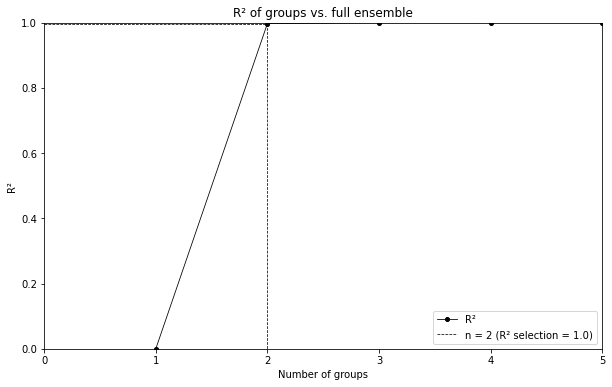

In [7]:
from xclim.ensembles import plot_rsqprofile
plot_rsqprofile(fig_data)